## EDA of Missing Data Experiments

This notebook assumes that the results for the following computations are present in `output_dir`:
```
output_dir/
---si/
------scale_free_1000/
------synthetic_internet_1000/
------us_power_grid/
```

In [1]:
# Settings
output_dir = "./missing_experiments_output/"

In [2]:
# Find all computed simulations / graphs
from os import listdir
from pprint import pprint

experiments_run = {}
simulations = listdir(output_dir)
for sim in simulations:
    experiments_run[sim] = listdir(output_dir + sim)

# Validate assumed results are present
assert "si" in experiments_run.keys(), "No results for 'si' dynamic found!"
assert "scale_free_1000" in experiments_run["si"], "No results for 'scale_free_1000' under 'si' dynamic found!"
assert "synthetic_internet_1000" in experiments_run["si"], "No results for 'synthetic_internet_1000' under 'si' dynamic found!"
assert "us_power_grid" in experiments_run["si"], "No results for 'us_power_grid' under 'si' dynamic found!"


## Loading, Normalizing and Pre-Formatting Data Utilities

In [3]:
"""Utils to load results"""
import os
from os.path import join
import pickle

def load_results(simulation, graph):
    """Loads the raw experiment results"""
    path = join(output_dir, simulation, graph)
    
    results_path = os.popen(f"find {path} -name 'results*'").read().replace("\n", "")
    with open(results_path, "rb") as f:
        results = pickle.load(f)
    return results

def load_main_ref_graph(simulation, graph):
    """Loads the unaltered experiment graph without any removed nodes"""
    path = join(output_dir, simulation, graph)
    
    results_path = os.popen(f"find {path} -name 'main_ref_graph*'").read().replace("\n", "")
    with open(results_path, "rb") as f:
        results = pickle.load(f)
    return results

In [4]:
def predictions_to_hop_distances(results, main_ref_graph, distances_callback=lambda x: x):
    """Computes all distances from the predicted_centers to the original_centers
    Computes the cross product of original_centers and predicted_centers
    Applies the given callback to the distances
    Returns all distances in a list"""
    
    shortest_path_lenghts = dict(nx.all_pairs_shortest_path_length(main_ref_graph))
    
    # refed by (missing_percent, sample_number, metric)
    hop_distances = {}
    
    for missing_percent, samples in r.items():
        for i, sample in enumerate(samples):
            if sample is None:
                continue

            real_center = sample["real_centers"][0]
            for metric, predicted_centers in sample["predicted_centers"].items():
                distances = [
                    shortest_path_lenghts[real_center][predicted_center]
                    for predicted_center in predicted_centers
                ]
                
                hop_distances[(missing_percent, i, metric)] = distances_callback(distances)

    return hop_distances


**Takes a long time if run the first time. Stores prepared data in `.pickle` files to speed up re-runs of this notebook.**

In [5]:
data_to_load = {
    "si": [
        "scale_free_1000",
        "synthetic_internet_1000",
        "us_power_grid",
    ],
}
total = sum([len(graphs) for sim, graphs in data_to_load.items()])

In [6]:
"""
Maps all detected sources to the distance to the original source.
Creates data for raw distances, best raw distance, mean raw distances
and for normalized distances, best normalized distance, mean normalized distances

All data is stored in a pickle file, as the computation can take a while and you probably dont want to repeat it
BEWARE: CACHES ARE EVIL AND YOU NEED TO REMOVE THE PICKLE FILE TO RECOMPUTE THESE DISTANCES!
"""

import os
import pickle
from tqdm import tqdm

# Load results from cache if present
filename = "_loaded_data.pickle"
if not os.path.exists(filename):
    loaded_data = {}
    
    
    with tqdm(total=total) as progress_bar:

        for sim, graphs in data_to_load.items():
            print(sim)
            for g in graphs:
                print(g)
                main_ref_graph = load_main_ref_graph(sim, g)
                # Unnormalized results
                # Map predictions to distances
                r = load_results(sim, g)
                raw_hop_distance_results = predictions_to_hop_distances(r, main_ref_graph)
                # Map to best
                r = load_results(sim, g)
                best = lambda distances: min(distances)
                best_raw_hop_distance_results = predictions_to_hop_distances(r, main_ref_graph, best)
                # Map to mean
                r = load_results(sim, g)
                mean = lambda distances: sum(distances) / len(distances)
                mean_raw_hop_distance_results = predictions_to_hop_distances(r, main_ref_graph, mean)

                # Normalized Results
                # Map predictions to normalized distances
                r = load_results(sim, g)
                diameter = nx.diameter(main_ref_graph)
                normalize_distances = lambda distances: [d / diameter for d in distances]
                diameter_normalized_distance_results = predictions_to_hop_distances(r, main_ref_graph, normalize_distances)
                # Map to best
                r = load_results(sim, g)
                best_normalized = lambda distances: best(normalize_distances(distances))
                best_diameter_normalized_distance_results = predictions_to_hop_distances(r, main_ref_graph, best_normalized)
                # Map to mean
                r = load_results(sim, g)
                mean_normalized = lambda distances: mean(normalize_distances(distances))
                mean_diameter_normalized_distance_results = predictions_to_hop_distances(r, main_ref_graph, mean_normalized)

                loaded_data[(sim, g)] = {
                    "raw": raw_hop_distance_results,
                    "best_raw": best_raw_hop_distance_results,
                    "mean_raw": mean_raw_hop_distance_results,
                    "diameter_normalized": diameter_normalized_distance_results,
                    "best_diameter_normalized": best_diameter_normalized_distance_results,
                    "mean_diameter_normalized": mean_diameter_normalized_distance_results,
                }
                progress_bar.update(1)

    with open(filename, "wb") as f:
        pickle.dump(loaded_data, f)
        
with open(filename, "rb") as f:
    loaded_data = pickle.load(f)

In [7]:
def average_over_all_samples(loaded_data, distance_key):
    """Averages available distances over all metrics"""
    averaged_data = {}
    for (sim, g) in loaded_data:
        collected_values = {}
        for (percent_missing, sample_num, metric), value in loaded_data[(sim, g)][distance_key].items():
            collected_values[(percent_missing, metric)] = collected_values.get((percent_missing, metric), []) + [value]
        
        averaged_values = {}
        for key in collected_values:
            if key[1] not in averaged_values.keys():
                averaged_values[key[1]] = {}
            averaged_values[key[1]][key[0]] = sum(collected_values[key]) / len(collected_values[key])
        
        averaged_data[(sim, g)] = averaged_values
    return averaged_data            

## Visualizations

In [8]:
name_mapping = {
    "scale_free_1000": "Scale Free (1000)",
    "synthetic_internet_1000": "Synthetic Internet (1000)",
    "us_power_grid": "US Power Grid",
}

In [9]:
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comparative_graph(loaded_data, key="mean_diameter_normalized"):
    """Plots for each graph the development of average hop distances"""

    if key not in ["best_diameter_normalized", "mean_diameter_normalized", "best_raw", "mean_raw"]:
        raise ValueError("Invalid key, make sure key is in loaded data and that its either mean or best")

    fig, axes = plt.subplots(1, total, figsize=(15,5), sharey=True)

    averaged_data = average_over_all_samples(loaded_data, key)
    
    for i, (sim, g) in tqdm(enumerate(averaged_data)):

        ax = axes[i]
        
        df = DataFrame(averaged_data[(sim, g)])
        
        df.plot(title=str((sim, g)), ax=ax, legend=False)

        colors = dict([(l.get_label(), l.get_color()) for l in ax.lines])
        
        for col in df.columns:
            l = sns.regplot(x=df.index, y=df[col], ax=ax, scatter=False, label=f"{col}-lin. reg.", color=colors[col],
                           # fit_ref=False,
                            ci=None,
                           )

        for line in ax.lines:
            line.set_label(" ".join([s.capitalize() for s in line.get_label().split("_")]))
            if "reg" in line.get_label():
                line.set_linestyle(":")
        
        ax.set_title(name_mapping[g])
        ax.set_xlabel("Missing percent")
        ax.set_ylabel("Diameter Norm. Hop Distance")

        ax.set_ylim([0,1])

    ax.legend(ncol=2, bbox_to_anchor=[0, -0.2]) 


3it [00:00, 49.36it/s]


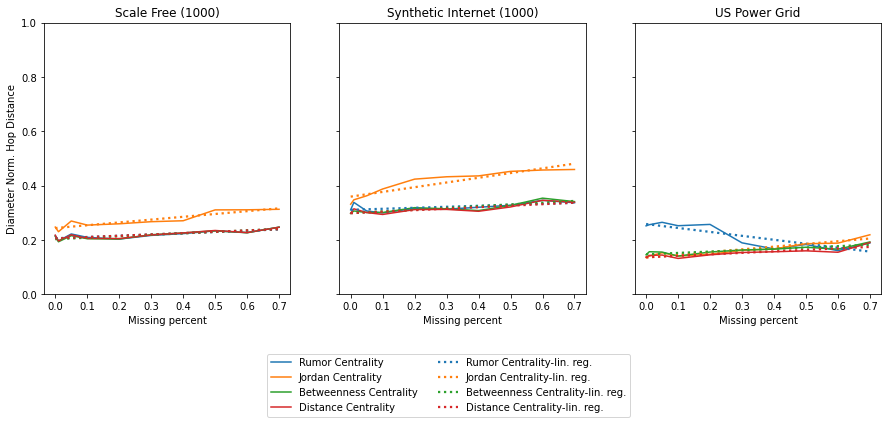

In [10]:
plot_comparative_graph(loaded_data, "mean_diameter_normalized")

3it [00:00, 53.55it/s]


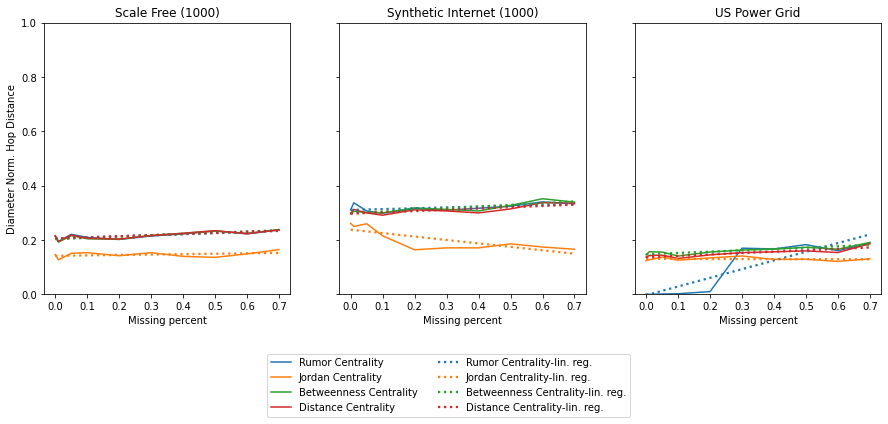

In [11]:
plot_comparative_graph(loaded_data, "best_diameter_normalized")

In [12]:
def get_max_change_table(averaged_data):
    """Get the maximum deviation from 0.0 in a table"""
    df = DataFrame(averaged_data)
    
    for key, metric_lookup in averaged_data.items():
        for metric, mp_lookup in metric_lookup.items():
            base = mp_lookup[0.0]
            max_mp, max_v = max(
                [(missing_percent, abs(value - base)) for missing_percent, value in mp_lookup.items()],
                key=lambda x:x[1],
            )
            
            df[key][metric] = f"{round(max_v, 3)} ({max_mp})"
    return df

In [32]:
def latex_print_max_change_table(table):
    """Helper to translate the max change table to latex"""
    x = table.transpose()
    for col in x.columns:
        s = " ".join(map(lambda x: x.capitalize(), col.split("_"))) + " "
        for y in x[col]:
            
            s += f"&{y})\t"
        s += r"\\"
        print(s)

In [14]:
avg_mean_diameter_normalized = average_over_all_samples(loaded_data, "mean_diameter_normalized")
avg_best_diameter_normalized = average_over_all_samples(loaded_data, "best_diameter_normalized")

In [33]:
t = get_max_change_table(avg_mean_diameter_normalized).reindex(
[
    "distance_centrality",
    "betweenness_centrality",
    "jordan_centrality",
    "rumor_centrality"
])
latex_print_max_change_table(t)

Distance Centrality &0.029 (0.7))	&0.048 (0.6))	&0.054 (0.7))	\\
Betweenness Centrality &0.034 (0.7))	&0.056 (0.6))	&0.047 (0.7))	\\
Jordan Centrality &0.066 (0.7))	&0.128 (0.7))	&0.083 (0.7))	\\
Rumor Centrality &0.031 (0.7))	&0.035 (0.6))	&0.091 (0.6))	\\


In [34]:
t = get_max_change_table(avg_best_diameter_normalized).reindex(
[
    "distance_centrality",
    "betweenness_centrality",
    "jordan_centrality",
    "rumor_centrality"
])
latex_print_max_change_table(t)

Distance Centrality &0.021 (0.01))	&0.041 (0.6))	&0.049 (0.7))	\\
Betweenness Centrality &0.026 (0.7))	&0.054 (0.6))	&0.046 (0.7))	\\
Jordan Centrality &0.019 (0.7))	&0.097 (0.2))	&0.017 (0.3))	\\
Rumor Centrality &0.022 (0.7))	&0.029 (0.6))	&0.187 (0.7))	\\


### Visualize the number of tied nodes over time

In [17]:
def get_avg_prediction_count_table(loaded_data, metric_to_count):
    averaged_data = {}
    
    for (sim, g) in loaded_data:
        collected_values = {}
        for (percent_missing, sample_num, metric), predicted_sources in loaded_data[(sim, g)]["raw"].items():
            if metric != metric_to_count:
                continue
            collected_values[percent_missing] = collected_values.get(percent_missing, []) + [len(predicted_sources)]
        
        averaged_data[(sim, g)] = dict([(key, sum(value)/len(value)) for key, value in collected_values.items()])        

    return DataFrame(averaged_data)

In [18]:
jordan_cent_predictions_df = get_avg_prediction_count_table(loaded_data, "jordan_centrality")
jordan_cent_predictions_df.columns = [name_mapping[c[1]] for c in jordan_cent_predictions_df.columns]
rumor_cent_predictions_df = get_avg_prediction_count_table(loaded_data, "rumor_centrality")
rumor_cent_predictions_df.columns = [name_mapping[c[1]] for c in rumor_cent_predictions_df.columns]

In [19]:
plt.rcParams["figure.dpi"] = 1024


fig, axes = plt.subplots(1,2, figsize=(10, 5))
jordan_cent_predictions_df.plot(
    legend=False,
    title="Jordan Centrality",
    xlabel="Missing Nodes (%)",
    ylabel="Number of Predicted Centers",
    ax=axes[0],
)


plt.rcParams["figure.dpi"] = 1024
rumor_cent_predictions_df.plot(
    legend=True,
    title="Rumor Centrality",
    logy=False,
    xlabel="Missing Nodes (%)",
    ylabel="Number of Predicted Centers",
    ax=axes[1],
)


fig.tight_layout()

### Visualize Node Degree Development for US Power Grid

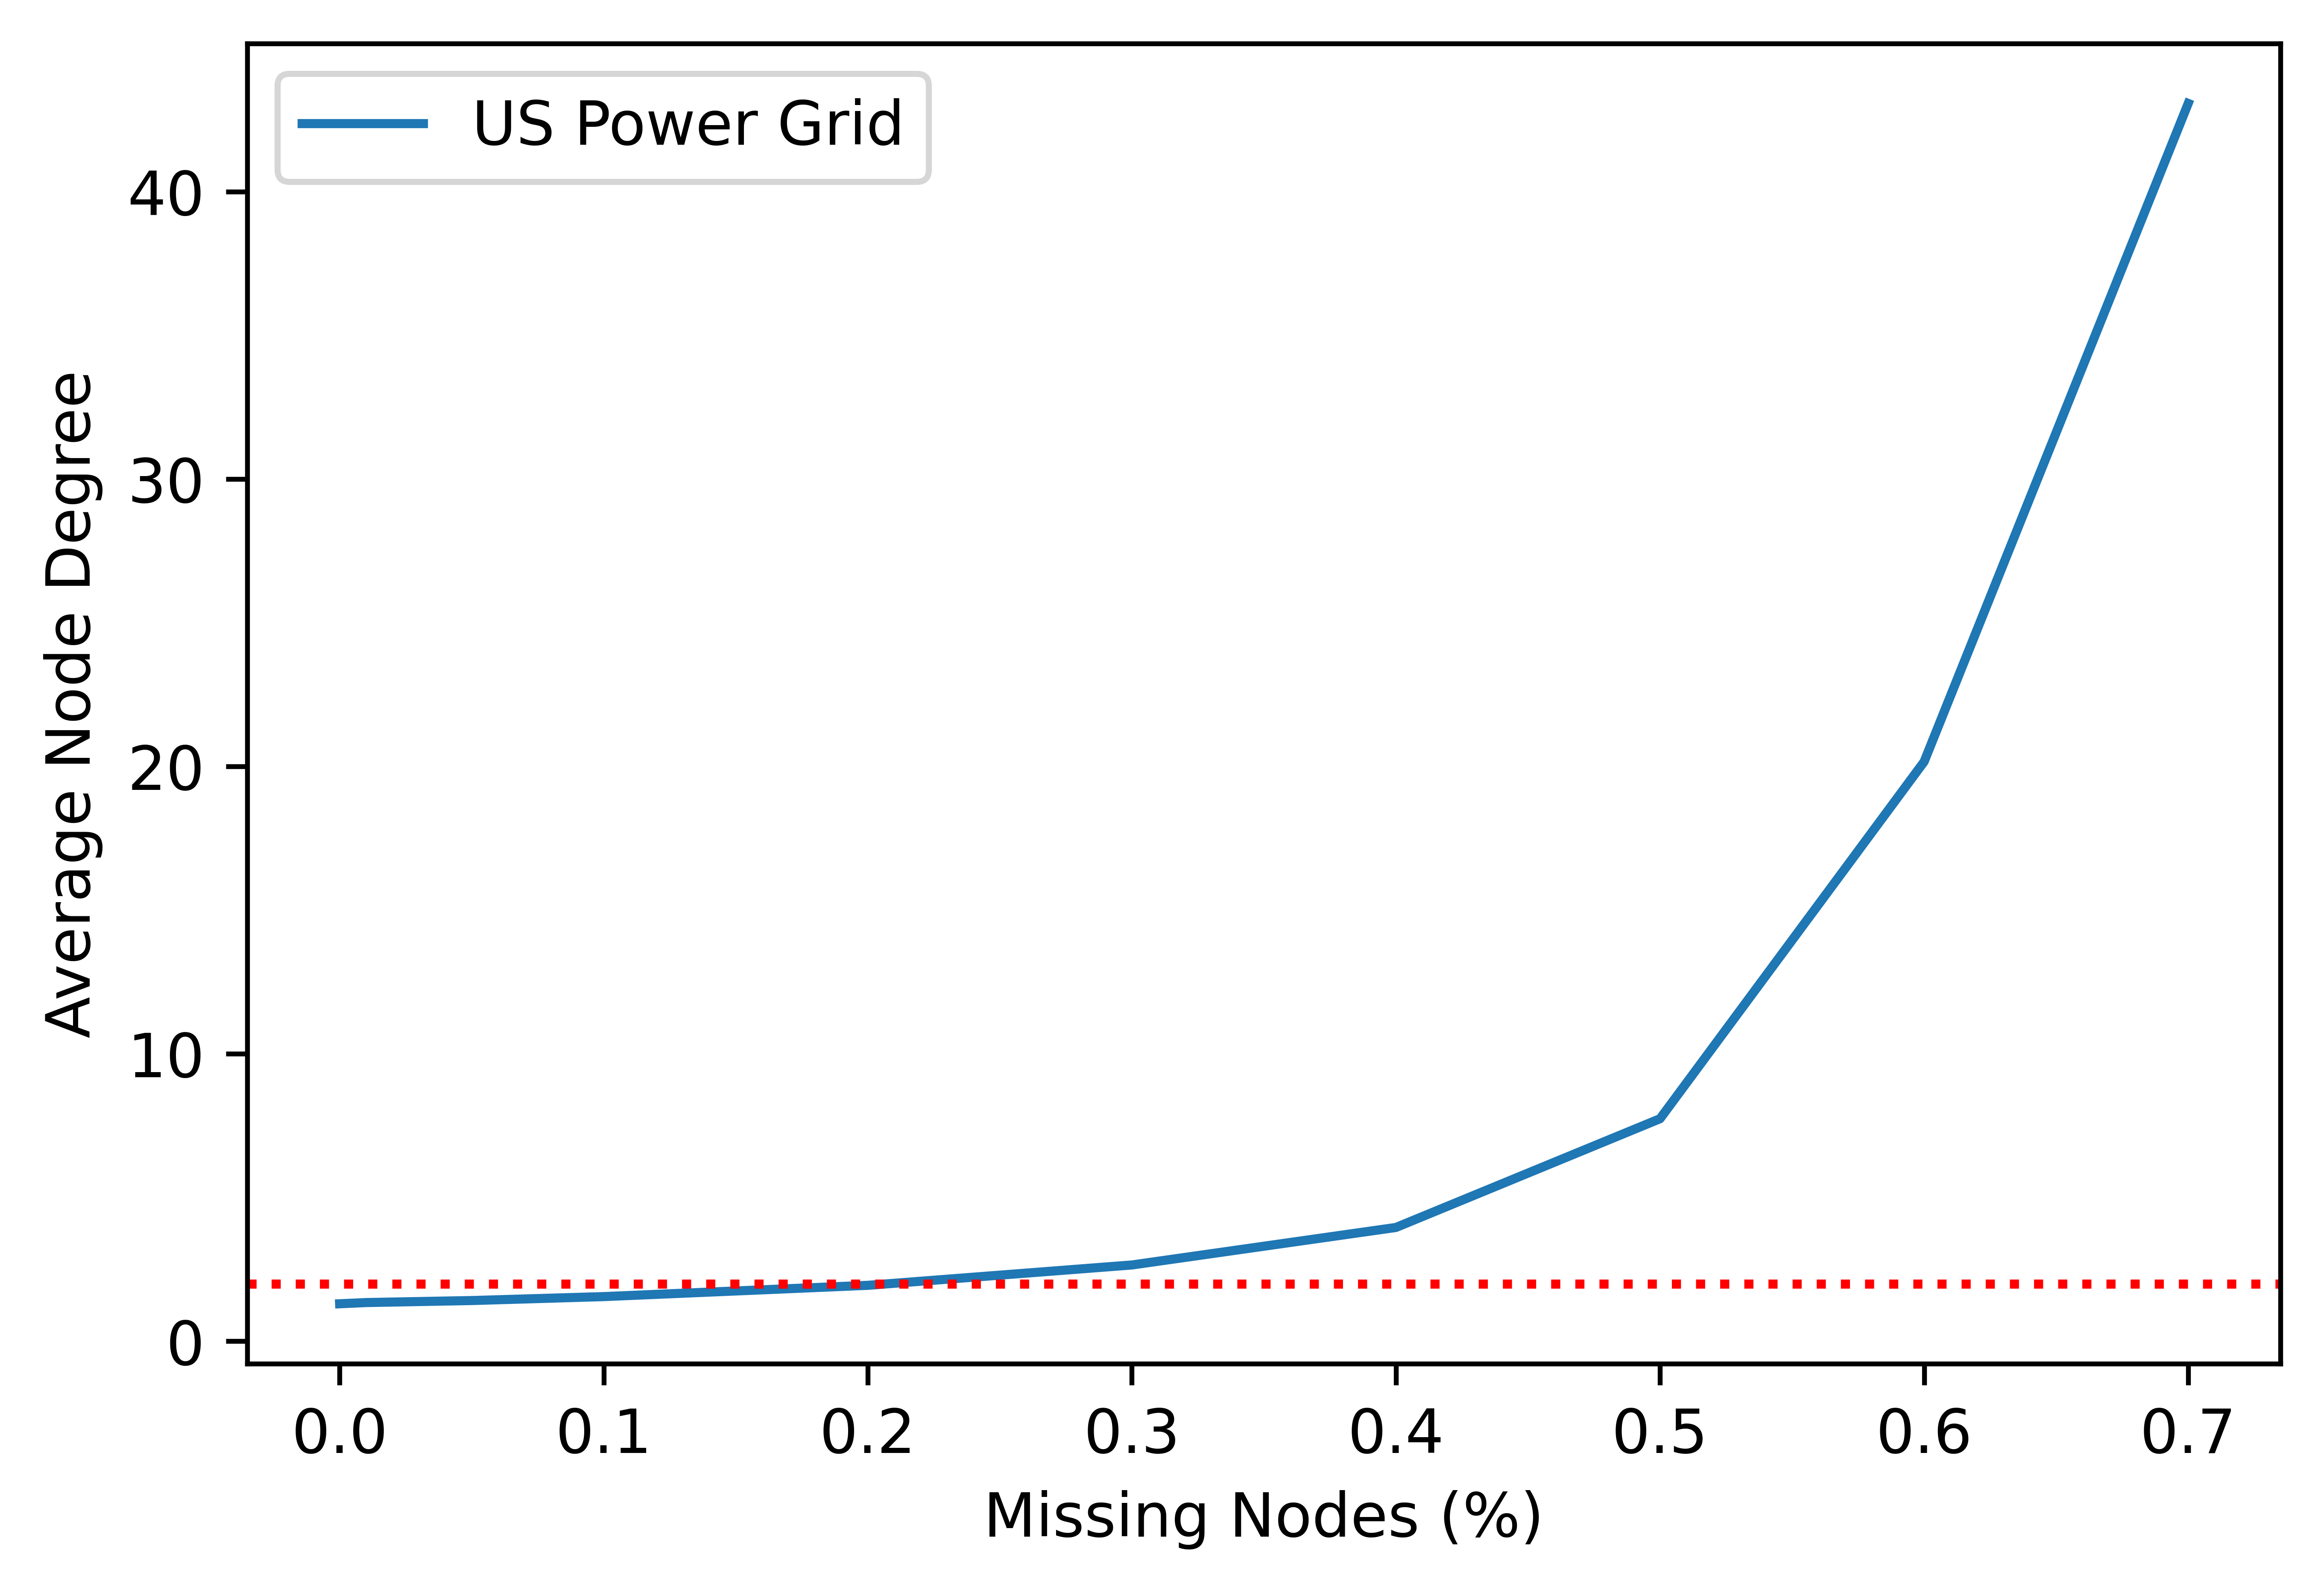

In [20]:
avg_degree_over_percent_missing = {}
for percent_missing, data in load_results("si", "us_power_grid").items():
    degrees = []
    for sample in data:
        if sample is None:
            continue
        ex_g = sample["ex_graph"]
        degrees.append(len(ex_g.edges) / len(ex_g.nodes))
    avg_degree_over_percent_missing[percent_missing] = sum(degrees)/len(degrees)

fig, ax = plt.subplots(1,1)
ax.plot(
    *zip(*sorted(avg_degree_over_percent_missing.items())),
    label="US Power Grid",
)
ax.set_xlabel("Missing Nodes (%)")
ax.set_ylabel("Average Node Degree")
ax.legend()

ax.axline((0.0, 2), (0.7, 2), color="red", linestyle=":")